In [74]:
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
# Variables
keep_cols = {
    'Datum von': 'datetime',
    'Erdgas [MWh] Originalauflösungen': 'fossile_gas',
    'Braunkohle [MWh] Originalauflösungen': 'lignite',
    'Steinkohle [MWh] Originalauflösungen': 'hard_coal',
    'Sonstige Konventionelle [MWh] Originalauflösungen': 'other_conventionals'
}

In [76]:
# Preprocess Generation Data
## Read in generation data for each region
areas_df_dict = {
    'f_hertz': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_50Hertz_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    ),
    'amprion': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_Amprion_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    ),
    'tennet': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_TenneT_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    ),
    'transnet_bw': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_TransnetBW_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    )
}

## Convert regional generation data
for area, df in areas_df_dict.items():
    # Rename columns that will be kept
    df = df.rename(columns=keep_cols)

    # Only keep columns from keep_cols
    df = df.loc[:, [c for c in df.columns if c in keep_cols.values()]]

    # Transform date columns to datetime and set index
    df['datetime'] = pd.to_datetime(df['datetime'], format="%d.%m.%Y %H:%M")
    df = df.set_index('datetime')

    # Transform columns to numeric
    for col in df.columns:
        if not pd.api.types.is_float_dtype(df[col]):
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(".", "", regex=False)
                .str.replace(",", ".", regex=False)
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Aggregate conventional generation
    df['total_generation'] = df.sum(axis=1, numeric_only=True)

    areas_df_dict[area] = df

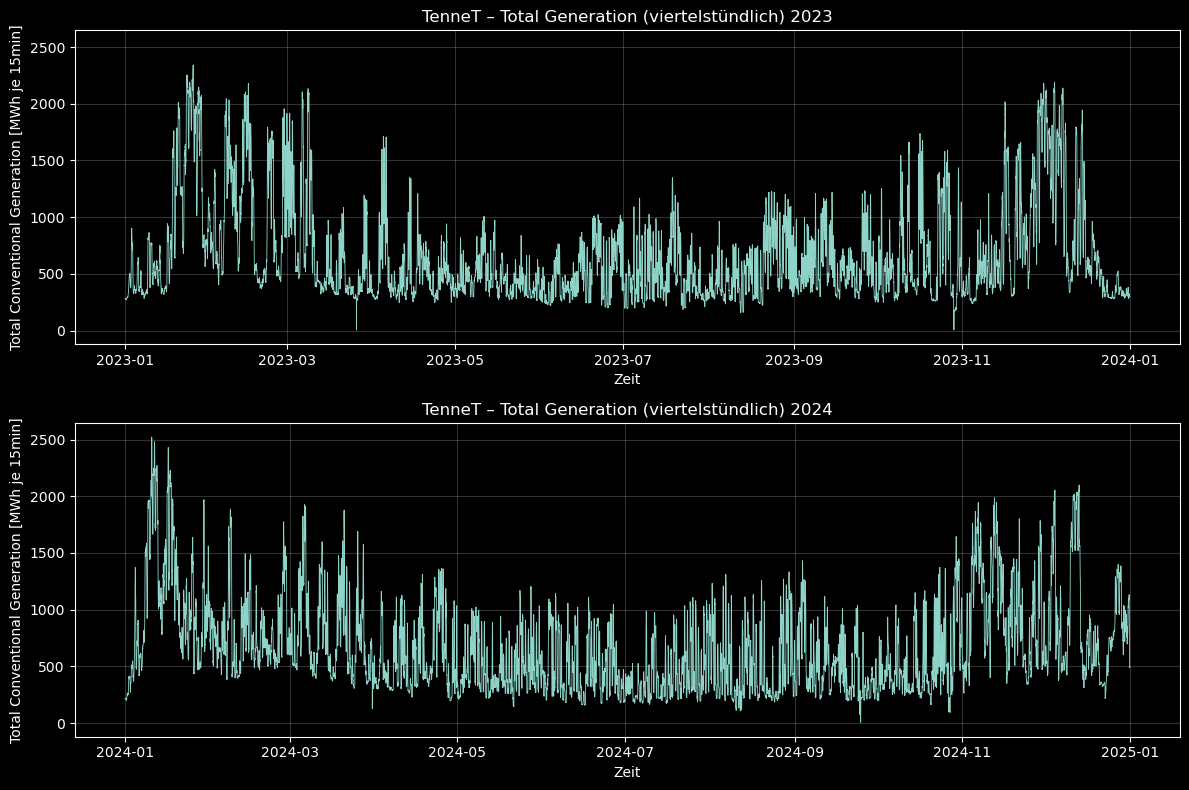

In [77]:
s = (
    areas_df_dict['tennet']['total_generation']
    .sort_index()
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharey=True)

for ax, year in zip(axes, [2023, 2024]):
    s_year = s[s.index.year == year]
    ax.plot(s_year.index, s_year.values, linewidth=0.6)
    ax.set_title(f"TenneT – Total Generation (viertelstündlich) {year}")
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Total Conventional Generation [MWh je 15min]")
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [78]:
# Preprocess Emissions Data
## Read in emissions data for each year and merge to one dataframe
emissions_2023 = pd.read_csv('../data/raw/agora/emissions_ger_2023_hourly.csv')
emissions_2024 = pd.read_csv('../data/raw/agora/emissions_ger_2024_hourly.csv')

## Concatenate and drop duplicate (last 2023 and first 2024)
emissions = pd.concat([emissions_2023, emissions_2024])
emissions.drop_duplicates(keep = 'first', inplace=True)

## Rename columns
emissions = emissions.rename(columns={
    'Braunkohle': 'lignite',
    'Erdgas': 'fossile_gas',
    'Andere': 'other_conventionals',
    'Steinkohle': 'hard_coal',
    'Absolute Emissionen': 'total_emissions',
    'CO₂-Emissionsfaktor des Strommix': 'aef'
})

## Convert types
emissions['Datetime'] = pd.to_datetime(emissions['Datetime'], format='%Y-%m-%dT%H:%M:%S')
emissions = emissions.set_index('Datetime')

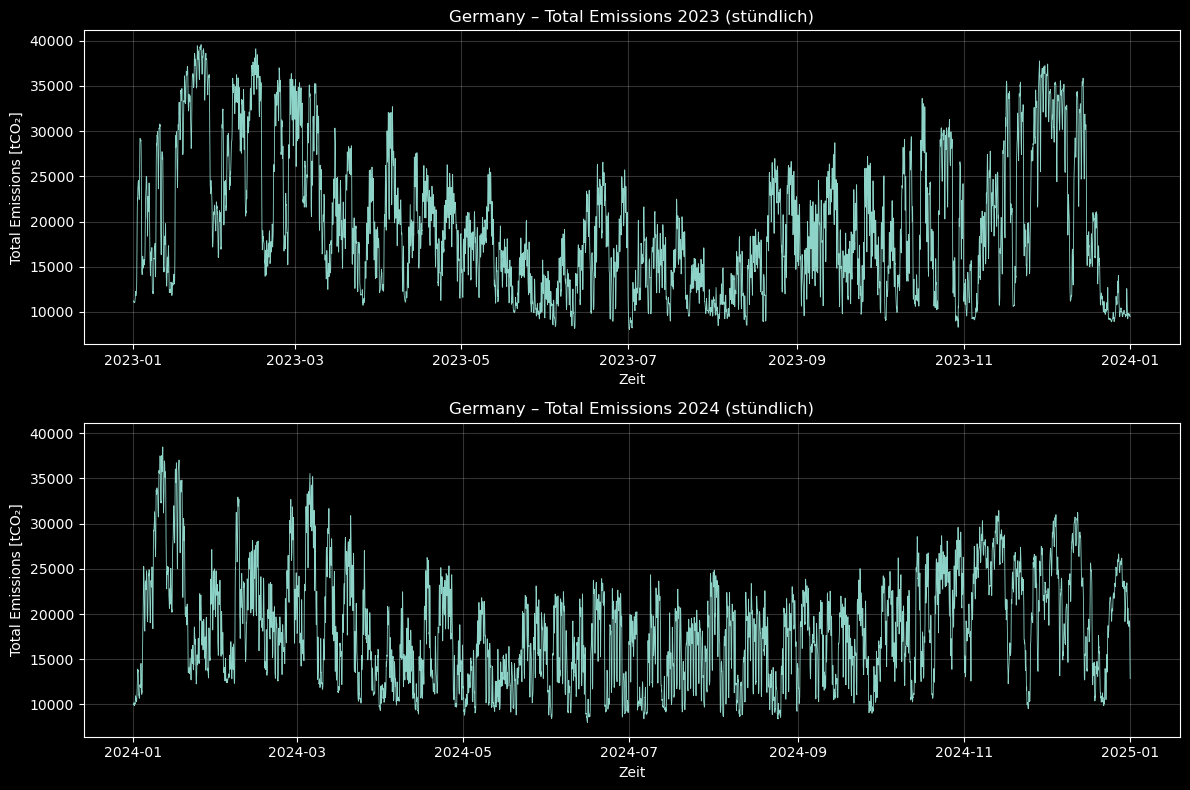

In [79]:
import matplotlib.pyplot as plt

e = emissions["total_emissions"].sort_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharey=True)

for ax, year in zip(axes, [2023, 2024]):
    e_year = e[e.index.year == year]
    ax.plot(e_year.index, e_year.values, linewidth=0.6)
    ax.set_title(f"Germany – Total Emissions {year} (stündlich)")
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Total Emissions [tCO₂]")  # falls Einheit anders ist: Label anpassen
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [81]:
# Save dataframes to a file

for area in areas_df_dict:
    min_date = areas_df_dict[area].index.min().strftime('%Y%m%d%H%M')
    max_date = areas_df_dict[area].index.max().strftime('%Y%m%d%H%M')
    areas_df_dict[area].to_csv(f'../data/interim/generation_{area}_{min_date}_{max_date}.csv')

min_date = emissions.index.min().strftime('%Y%m%d%H%M')
max_date = emissions.index.max().strftime('%Y%m%d%H%M')
emissions.to_csv(f'../data/interim/emissions_germany_{min_date}_{max_date}.csv', index=True)